In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import datetime
from pmdarima.arima import ADFTest


Usage of Time Series model: ARIMA to predict stock prices,
Usage of Auto ARIMA: It is known to be more accurate and powerful compared to the manual ARIMA, as it will select more appropriate parameters. 
More things to explore: Selecting the correct time frame, how to improve the accuracy of ARIMA

In [145]:
def write_ans_toCSV(filename,answers):
    submissions = pd.read_csv("sample_submission.csv")
    print(submissions)
    submissions['Predicted']= answers
    submissions.to_csv(filename,index=False)


Date
2010-09-13    15400
2010-09-14    15200
2010-09-15    15140
2010-09-16    15140
2010-09-17    15460
              ...  
2017-04-06    41840
2017-04-07    41600
2017-04-10    41940
2017-04-11    41600
2017-04-12    41900
Name: Close, Length: 1628, dtype: int64
AxesSubplot(0.125,0.2;0.775x0.68)


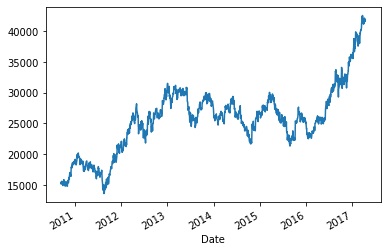

In [140]:
df = pd.read_csv('data.csv')
ans = pd.read_csv('sample_submission.csv')
ans['Date']=pd.to_datetime(ans['Date'])
df['Date']=pd.to_datetime(df["Date"])
df.set_index("Date",inplace=True)
stocks=df["Close"]


print(stocks)
print(stocks.plot())

We will now test is the data is stationary using the ADF Test. This will indicate whether we have to use differencing to make the data stationary (although this will already be automatically computed by the Auto ARIMA model).

In [3]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(stocks)

(0.8958134521967053, True)

ADF Test shows that the data is already stationary, hence integration/ differencing is not necessary.
Now it is time to split the data into a training and test set. 
Split according to the 80-20 split rule (this follows from the Pareto principle, where an 80/20 statistical split is a commonly occuring ratio). 
This 80-20 ratio ensures that there is sufficient training and testing data to minimise the variance of the trained model and the performance statistic respectively.

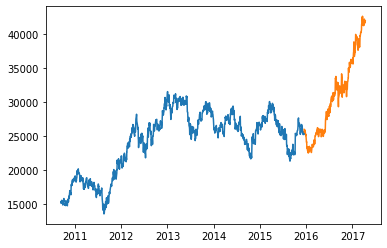

In [4]:
length = 1628
upper_limit=int(0.8*1628)
ARIMA_train_data = stocks[:upper_limit]
ARIMA_test_data=stocks[upper_limit:]
#print(len(ARIMA_train_data))
#print(len(ARIMA_test_data))
plt.plot(ARIMA_train_data)
plt.plot(ARIMA_test_data)
plt.show()

Parameters for auto_arima. Set seasonal to False because stock prices are not known to be seasonal, and test each parameter(p and q) from 0 to 3. d=None essentially means that we do not have to use any differentials/ integration to make the data stationary. Auto_ARIMA will then use AIC (a means of measuring the error), to figure out the best parameters to use for the stock prediction model.

In [5]:
model = pm.auto_arima(ARIMA_train_data,start_p=0,start_q=0,test='adf', d=None,seasonal=False,
                     suppress_warnings=True, error_action="ignore", max_p=3,max_q=3,
                     trace=True,m=1,D=0,start_P=0,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19394.563, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19395.227, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19394.992, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19393.017, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19394.104, Time=1.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.956 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1302
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9695.509
Date:                Sat, 02 Oct 2021   AIC                          19393.017
Time:                        10:38:59   BIC                          19398.188
Sample:                             0   HQIC                         19394.957
                               - 1302                                  

Utilising the model to predict data, and thereafter comparing the predicted data with the test data

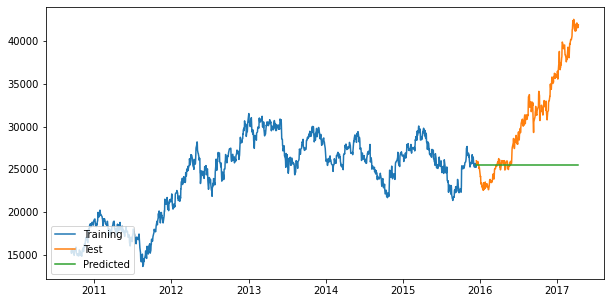

In [6]:
ARIMA_predicted_stock_prices=pd.DataFrame(model.predict(n_periods=326),index=ARIMA_test_data.index)
ARIMA_predicted_stock_prices.columns=['predicted_price']
plt.figure(figsize=(10,5))
plt.plot(ARIMA_train_data,label="Training")
plt.plot(ARIMA_test_data,label="Test")
plt.plot(ARIMA_predicted_stock_prices,label="Predicted")
plt.legend(loc='lower left')
plt.show()

Validating the data through RMSE. We will use RMSE to compare how accurate the models are.

In [7]:
from sklearn.metrics import mean_squared_error

#print(ARIMA_test_data)
#print(ARIMA_predicted_stock_prices)

ARIMA_test_data_lst = ARIMA_test_data.tolist()
ARIMA_predicted_stock_prices_lst=ARIMA_predicted_stock_prices["predicted_price"].tolist()

#print(ARIMA_test_data_lst)
#print(ARIMA_predicted_stock_prices_lst)

print("The mean squared error is", mean_squared_error(ARIMA_test_data_lst,ARIMA_predicted_stock_prices_lst,squared=False))



The mean squared error is 7892.814857854459


Using the ARIMA model to make predictions, but using the entire dataset. In my opinion, this would be more accurate than using just the training dataset. This is because, the entire dataset also contains more recent values. 

In [127]:
model = pm.auto_arima(stocks,start_p=0,start_q=0,test='adf', d=None,seasonal=False,
                     suppress_warnings=True, error_action="ignore", max_p=3,max_q=3,
                     trace=True,m=1,D=0,start_P=0,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24390.269, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24390.072, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24389.640, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24390.549, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24386.516, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24368.388, Time=0.90 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24379.311, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24370.041, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24368.911, Time=1.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24370.108, Time=0.75 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24369.957, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24371.688, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=24369.958, Time=0.31 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 6.099 seconds
         

Date
2010-09-13    15400
2010-09-14    15200
2010-09-15    15140
2010-09-16    15140
2010-09-17    15460
              ...  
2017-04-06    41840
2017-04-07    41600
2017-04-10    41940
2017-04-11    41600
2017-04-12    41900
Name: Close, Length: 1628, dtype: int64
            predicted_price
Date                       
2017-04-13     41953.247619
2017-04-14     41959.193845
2017-04-17     41964.518057
2017-04-18     41975.139191
2017-04-19     41989.232195
...                     ...
2021-09-07     59797.763531
2021-09-08     59814.299929
2021-09-09     59830.836328
2021-09-10     59847.372726
2021-09-13     59863.909124

[1086 rows x 1 columns]


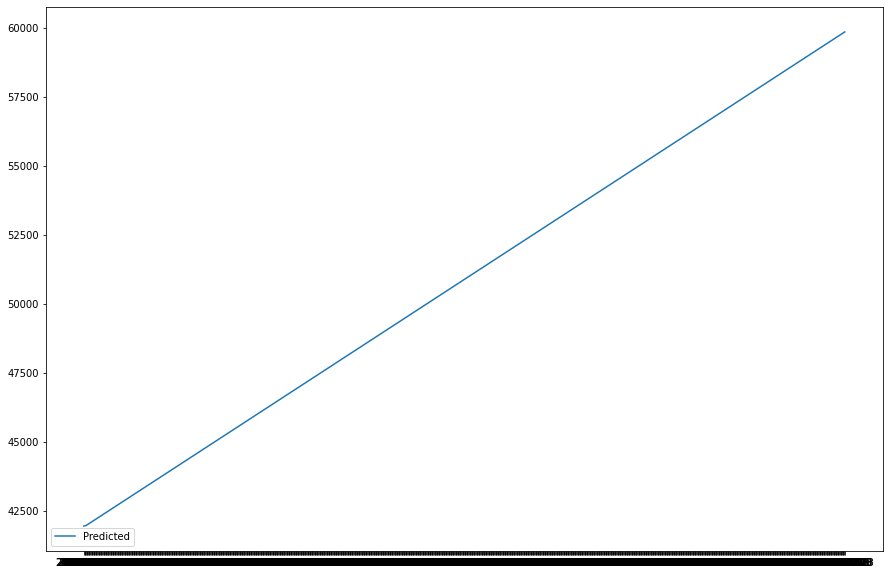

[41953.24761932145, 41959.19384482033, 41964.51805675454, 41975.13919130015, 41989.23219480339, 42004.91391002688, 42021.19641456814, 42037.67290554967, 42054.201457541894, 42070.740037779775, 42087.27878027248, 42103.816419263516, 42120.35333103002, 42136.88990929906, 42153.42636126207, 42169.962772382074, 42186.49917251827, 42203.03557052858, 42219.57196849815, 42236.1083666976, 42252.644765049365, 42269.18116347114, 42285.71756191947, 42302.253960376394, 42318.790358835635, 42335.32675729533, 42351.86315575503, 42368.39955421469, 42384.935952674314, 42401.472351133925, 42418.00874959353, 42434.545148053134, 42451.08154651274, 42467.61794497234, 42484.15434343195, 42500.69074189155, 42517.227140351155, 42533.76353881076, 42550.29993727036, 42566.83633572997, 42583.37273418957, 42599.909132649176, 42616.44553110878, 42632.981929568385, 42649.51832802799, 42666.05472648759, 42682.5911249472, 42699.1275234068, 42715.663921866406, 42732.20032032601, 42748.736718785614, 42765.27311724522,

In [147]:
ans = pd.read_csv('sample_submission.csv')
ans.set_index("Date",inplace=True)
new_ARIMA_predicted_stock_prices=pd.DataFrame(model.predict(n_periods=1086),index=ans.index)
new_ARIMA_predicted_stock_prices.columns=['predicted_price']
#print(ARIMA_predicted_stock_prices)
print(stocks)
print(ARIMA_predicted_stock_prices)
plt.figure(figsize=(15,10))
#plt.plot(stocks,label="Historical")
plt.plot(ARIMA_predicted_stock_prices,label="Predicted")
plt.legend(loc='lower left')
plt.show()
#We can see that there is a 'linear' trend when we plot the graph

submit_values=new_ARIMA_predicted_stock_prices['predicted_price'].tolist()
print(submit_values)
write_ans_toCSV("Keane Ong_PredictedValues2.csv",submit_values)

The ARIMA model may not be the best means of capturing unobservable data in the stock market - i.e. consumer sentiment etc., a better, more accurate means of forecasting may entail the use of Neural Networks. 

## USE of LSTM (Long Short Term Memory) Model
LSTM is able to more accurately weigh previous information for stock prices, it is able to classify, process and predict time series given lags of unknown duration. 

We will start by manipulating the data to make it compatible with the Stacked LSTM Model.
This involves reshaping the data such that the values are scaled between 0 and 1, and such that there is only 1 column in an array. 
We will split the training and test data according to the 80/20 split - 80% of the data will be training data, whereas 20% of the data will be the test data.
The Stacked LSTM works by utilising the previous data to predict future data. Hence, we will arrange the data in accordance with this via the create_LSTMdataset function.

Note: For the min max scaler/ normalisation, we need to seperate the training and test sets before normalising, otherwise there will be leakage between the test & training sets. 



In [67]:
import array
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

#obtaining the correct data from the dataset
LSTM_Data=(df.reset_index()['Close'])
print(len(LSTM_Data))

#performing the splitting of DataSets into train and test
LSTMtraining_len=int(len(LSTM_Data)*0.80)
LSTMtrain=np.array(LSTM_Data[:LSTMtraining_len])
LSTMtest=np.array(LSTM_Data[LSTMtraining_len:])  

#scaling the data to the range between 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
LSTMtrain=scaler.fit_transform(LSTMtrain.reshape(-1,1))
LSTMtest=scaler.fit_transform(LSTMtest.reshape(-1,1))

print(LSTMtrain.shape)

#creating a function to split the data into x and y, where x input predicts y. setting the timestep as 200
def create_LSTMdataset(dataset,time_step):
    X=[]
    Y=[]
    for i in range(len(dataset)-time_step-1):
        #print(dataset[0:i,0])
        a=dataset[i:(i+time_step),0]
        X.append(a)
        Y.append(dataset[i+time_step,0])
    X=np.array(X)
    Y=np.array(Y)
    return X,Y

timesteps=200
print(LSTMtrain.shape)
LSTM_X_train, LSTM_Y_train = create_LSTMdataset(LSTMtrain,timesteps)
print(LSTM_X_train.shape)
LSTM_X_test, LSTM_Y_test= create_LSTMdataset(LSTMtest,timesteps)

# Conducting masking (not necessary)
# embedding = layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)
# LSTM_X_train_masked_output = embedding(LSTM_X_train)
#LSTM_X_test_masked_output = embedding(LSTM_X_test)

#print(LSTM_X_train_masked_output._keras_mask)
#print(LSTM_X_test_masked_output._keras_mask)

# def create_LSTMdataset2(dataset):
#     X=[]
#     Y=[]
#     for i in range(1, len(dataset)):
#         #print(dataset[0:i,0])
#         X.append(dataset[:i,0])
#         Y.append(dataset[i,0])
#     #X=tf.keras.preprocessing.sequence.pad_sequences(np.array(X),padding="post")
#     X=np.array(X)
#     Y=np.array(Y)
#     return X,Y



1628
(1302, 1)
(1302, 1)
(1101, 200)


There is a need to reshape the X data, such that it is in 3D. The LSTM only accepts 3D data. 

In [9]:
# print(LSTM_X_train.shape)
# print(LSTM_X_test.shape)

#reshaping the 2D arrays into 3D arrays
LSTM_X_train=LSTM_X_train.reshape(LSTM_X_train.shape[0],LSTM_X_train.shape[1],1)
LSTM_X_test=LSTM_X_test.reshape(LSTM_X_test.shape[0],LSTM_X_test.shape[1],1)
LSTM_Y_train=LSTM_Y_train.reshape(LSTM_Y_train.shape[0],1)
LSTM_Y_test=LSTM_Y_test.reshape(LSTM_Y_test.shape[0],1)


# print(LSTM_X_train.shape)
# print(LSTM_X_test.shape)
# print(LSTM_Y_train.shape)
# print(LSTM_Y_test.shape)


Now, it is time to build,compile and train the LSTM model.

A few conceptual notes:
- LSTM takes an input of fixed lengths 
- X_train must be the shape of (batch_size, window_size or time_steps, number of features); batch size is the number of samples(or datapoints); the window_size/ time_steps is basically "How many features/ preceding dates we shall use to predict the next date"), the 1 at the end is the number of features per date/ iteration.
- y_train must be the shape of (batch_size, n) > batch size is the number of output units; n is the number of timesteps ahead that you are predicting the value, relative to the previous y value (not how many x values you are taking to predict the y value). If you are predicting the immediate next value, n=1.
- The arrays within each array need to be of regular size
- The input_shape of the LSTM is [batch, timesteps, number of features], but when we specify only 2 parameters the batchsize will be any size and the timesteps and features will be covered by the parameters, i.e input_shape=(2,10), this means batch=any size, timesteps=2,number of features=10 
- Batch size is the number of samples to work through before updating the model's parameters internally. We choose a mini-batch gradient descent here, of roughly 32.
- Epoch is the hyperparameter that defines the number of times the algorithm will work through the entire training set. We iterate 15 times. 


In [10]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(LSTM_X_train.shape[1],1))) #this ensures that the input shape follows the correct 'format'
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

### Printing the inputs of the model to double check what inputs are required for the model
# [print(i.shape, i.dtype) for i in model.inputs]
# [print(o.shape, o.dtype) for o in model.outputs]
# [print(l.name, l.input_shape, l.dtype) for l in model.layers]

print(LSTM_X_train.shape)
model.fit(LSTM_X_train,LSTM_Y_train,epochs=10,batch_size=32)
#try arrays of same sizes for the training input. 

(1101, 200, 1)
Epoch 1/10
35/35 [==============================] - 15s 208ms/step - loss: 0.0526
Epoch 2/10
35/35 [==============================] - 7s 197ms/step - loss: 0.0056
Epoch 3/10
35/35 [==============================] - 7s 202ms/step - loss: 0.0041
Epoch 4/10
35/35 [==============================] - 6s 177ms/step - loss: 0.0040
Epoch 5/10
35/35 [==============================] - 6s 173ms/step - loss: 0.0037
Epoch 6/10
35/35 [==============================] - 7s 190ms/step - loss: 0.0036
Epoch 7/10
17/35 [=============>................] - ETA: 3s - loss: 0.0034

KeyboardInterrupt: 

Making predictions using the stacked LSTM. Thereafter, we validate the model by producing graphs and calculating the RMSE. 

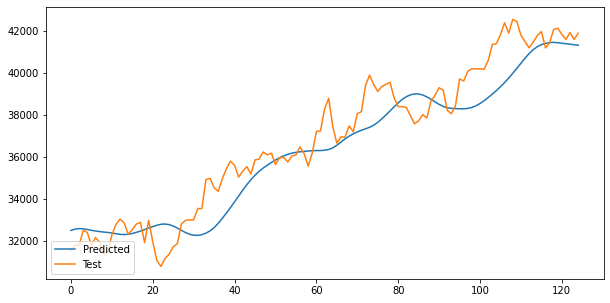

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
1195.478899256284


In [ ]:
LSTM_test_predict=model.predict(LSTM_X_test)  #prediction will output an array 
LSTM_test_predict=scaler.inverse_transform(LSTM_test_predict) #we will then convert the array from scaled values to the original values

LSTM_testDatavalues=df.reset_index()['Close'][LSTMtraining_len+timesteps+1:] #converting to series object in order to plot graph
LSTM_testDatavalues=LSTM_testDatavalues.reset_index(drop=True) 
LSTM_test_predictvalues = pd.DataFrame(LSTM_test_predict).iloc[:,0] #converting to series object in order to plot graph
plt.figure(figsize=(10,5))
plt.plot(LSTM_test_predictvalues,label="Predicted")
plt.plot(LSTM_testDatavalues,label="Test")
plt.legend(loc='lower left')
plt.show()

from sklearn.metrics import mean_squared_error
print(type(LSTM_test_predictvalues))
print(type(LSTM_testDatavalues))
LSTM_test_predictvalues_lst = LSTM_test_predictvalues.tolist()
LSTM_testDatavalues_lst = LSTM_testDatavalues.tolist()
#print(LSTM_test_predictvalues_lst)
#print(LSTM_testDatavalues_lst)
print(mean_squared_error(LSTM_testDatavalues_lst,LSTM_test_predictvalues_lst,squared=False))



The above is an explanation of using an LSTM model to predict the stock prices. It used a timestep of about 200, essentially meaning that 200 previous dates were used to predict the next date. However, the optimal number of timesteps is debatable: Given that different investors use different time frames for prediction. To obtain the most accurate model, we will try different timesteps of about 50, 100, 150, 200. These timestep values are not randomly selected. Although its not entirely the same, this 'kind-of' draws parallels with how investors use information from the previous 50, 100, 200 days (through moving averages), to predict the stock trends of the next day. 

Hence, we will now create a function that we will iterate with, to obtain the best model parameters.

In [ ]:
def optimal_LSTM_model(timesteps):
    #obtaining the correct data from the dataset
    LSTM_Data=(df.reset_index()['Close'])

    #performing the splitting of DataSets into train and test
    
    LSTMtraining_len=int(len(LSTM_Data)*0.80)
    LSTMtrain=np.array(LSTM_Data[:LSTMtraining_len])
    LSTMtest=np.array(LSTM_Data[LSTMtraining_len:])  
    
    #scaling the data to the range between 0 and 1
    
    scaler=MinMaxScaler(feature_range=(0,1))
    LSTMtrain=scaler.fit_transform(LSTMtrain.reshape(-1,1))
    LSTMtest=scaler.fit_transform(LSTMtest.reshape(-1,1))
    LSTM_X_train, LSTM_Y_train = create_LSTMdataset(LSTMtrain,timesteps)
    LSTM_X_test, LSTM_Y_test= create_LSTMdataset(LSTMtest,timesteps)

    LSTM_X_train=LSTM_X_train.reshape(LSTM_X_train.shape[0],LSTM_X_train.shape[1],1)
    LSTM_X_test=LSTM_X_test.reshape(LSTM_X_test.shape[0],LSTM_X_test.shape[1],1)
    LSTM_Y_train=LSTM_Y_train.reshape(LSTM_Y_train.shape[0],1)
    LSTM_Y_test=LSTM_Y_test.reshape(LSTM_Y_test.shape[0],1)

    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(LSTM_X_train.shape[1],1))) #this ensures that the input shape follows the correct 'format'
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    model.fit(LSTM_X_train,LSTM_Y_train,epochs=10,batch_size=32)

    LSTM_test_predict=model.predict(LSTM_X_test)  #prediction will output an array 
    LSTM_test_predict=scaler.inverse_transform(LSTM_test_predict) #we will then convert the array from scaled values to the original values

    LSTM_testDatavalues=df.reset_index()['Close'][LSTMtraining_len+timesteps+1:] #converting to series object in order to plot graph
    LSTM_testDatavalues=LSTM_testDatavalues.reset_index(drop=True) 
    LSTM_test_predictvalues = pd.DataFrame(LSTM_test_predict).iloc[:,0] #converting to series object in order to plot graph
    # plt.figure(figsize=(10,5))
    # plt.plot(LSTM_test_predictvalues,label="Predicted")
    # plt.plot(LSTM_testDatavalues,label="Test")
    # plt.legend(loc='lower left')
    # plt.show()
    LSTM_test_predictvalues_lst = LSTM_test_predictvalues.tolist()
    LSTM_testDatavalues_lst = LSTM_testDatavalues.tolist()
    #print(LSTM_test_predictvalues_lst)
    #print(LSTM_testDatavalues_lst)
    return mean_squared_error(LSTM_testDatavalues_lst,LSTM_test_predictvalues_lst,squared=False)

lst_timesteps={50:[],100:[],200:[]}

def obtainRSME(lst_of_timesteps):
    for time in lst_of_timesteps:
        lst_of_timesteps[time].append(optimal_LSTM_model(time))
    return lst_of_timesteps

obtainRSME(lst_timesteps)

new_lst_timesteps={75:[],125:[],150:[]}
print(obtainRSME(new_lst_timesteps))

Epoch 1/10
40/40 [==============================] - 12s 54ms/step - loss: 0.0530
Epoch 2/10
40/40 [==============================] - 2s 52ms/step - loss: 0.0048
Epoch 3/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0035
Epoch 4/10
40/40 [==============================] - 2s 52ms/step - loss: 0.0034
Epoch 5/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0032
Epoch 6/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0032
Epoch 7/10
40/40 [==============================] - 2s 53ms/step - loss: 0.0029
Epoch 8/10
40/40 [==============================] - 2s 53ms/step - loss: 0.0027
Epoch 9/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0026
Epoch 10/10
40/40 [==============================] - 2s 53ms/step - loss: 0.0025
Epoch 1/10
38/38 [==============================] - 16s 112ms/step - loss: 0.0592
Epoch 2/10
38/38 [==============================] - 4s 115ms/step - loss: 0.0056
Epoch 3/10
38/38 [=================

{50: [1140.2485123779595],
 100: [1061.1554992884144],
 200: [1258.0689310005735]}

***NOTE*** Initially I ran the LSTM with a lag of 1. This essentially means that a set number of all of the previous values would predict the next immediate value. However, I realise that this has to be adapted because the forecasting requires you to predict about 1087 values in advance. Thus, I have to modify the algorithm to include the lag.
As it seems like the dataset (of about 1628 values) is not large enough to be split into 2 non-overlapping/ seperate portions, we need to split the dataset into the training set containing the first 1387 values, and the test set containing the final 1387 values of the dataset. This will require improvisation.

I will try to implement this in a new algorithm below, but definitely, I would the validation with a pinch of salt (because of the overlap between the different datasets) - the validation may not be all that useful, but I guess it opens our minds to new ideas. 

For more accuracy, the final model should be trained on all the data. 

1388
1388
Epoch 1/10
4/4 [==============================] - 5s 173ms/step - loss: 0.3509
Epoch 2/10
4/4 [==============================] - 1s 181ms/step - loss: 0.1595
Epoch 3/10
4/4 [==============================] - 1s 228ms/step - loss: 0.0414
Epoch 4/10
4/4 [==============================] - 1s 209ms/step - loss: 0.0085
Epoch 5/10
4/4 [==============================] - 1s 208ms/step - loss: 0.0266
Epoch 6/10
4/4 [==============================] - 1s 173ms/step - loss: 0.0131
Epoch 7/10
4/4 [==============================] - 1s 170ms/step - loss: 0.0039
Epoch 8/10
4/4 [==============================] - 1s 175ms/step - loss: 0.0093
Epoch 9/10
4/4 [==============================] - 1s 212ms/step - loss: 0.0029
Epoch 10/10
4/4 [==============================] - 1s 215ms/step - loss: 0.0038


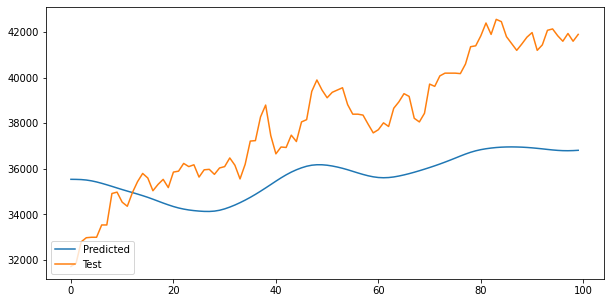

3173.232323277622


In [114]:
def create_LR_LSTMdataset(dataset,time_step):
    X=[]
    Y=[]
    lag=1087
    for i in range(len(dataset)-time_step-1-lag):
        #print(dataset[0:i,0])
        a=dataset[i:(i+time_step),0]
        X.append(a)
        Y.append(dataset[i+time_step+lag,0])
    X=np.array(X)
    Y=np.array(Y)
    return X,Y

def long_range_LSTM_model(timesteps):
    #obtaining the correct data from the dataset
    
    LSTM_Data=(df.reset_index()['Close'])

    #performing the splitting of DataSets into train and test
    
    #LSTMtraining_len=int(len(LSTM_Data)*0.80)
    LSTMtrain=np.array(LSTM_Data[:1388])
    LSTMtest=np.array(LSTM_Data[240:])  

    #scaling the data to the range between 0 and 1
    
    scaler=MinMaxScaler(feature_range=(0,1))
    LSTMtrain=scaler.fit_transform(LSTMtrain.reshape(-1,1))
    LSTMtest=scaler.fit_transform(LSTMtest.reshape(-1,1))
    print(len(LSTMtrain))
    print(len(LSTMtest))
    LSTM_X_train, LSTM_Y_train = create_LR_LSTMdataset(LSTMtrain,timesteps)
    LSTM_X_test, LSTM_Y_test= create_LR_LSTMdataset(LSTMtest,timesteps)

    LSTM_X_train=LSTM_X_train.reshape(LSTM_X_train.shape[0],LSTM_X_train.shape[1],1)
    LSTM_X_test=LSTM_X_test.reshape(LSTM_X_test.shape[0],LSTM_X_test.shape[1],1)
    LSTM_Y_train=LSTM_Y_train.reshape(LSTM_Y_train.shape[0],1)
    LSTM_Y_test=LSTM_Y_test.reshape(LSTM_Y_test.shape[0],1)

    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(LSTM_X_train.shape[1],1))) #this ensures that the input shape follows the correct 'format'
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    model.fit(LSTM_X_train,LSTM_Y_train,epochs=10,batch_size=32)

    LSTM_test_predict=model.predict(LSTM_X_test)  #prediction will output an array 
    LSTM_test_predict=scaler.inverse_transform(LSTM_test_predict) #we will then convert the array from scaled values to the original values

    LSTM_testDatavalues=df.reset_index()['Close'][240+timesteps+1+1087:] #converting to series object in order to plot graph
    LSTM_testDatavalues=LSTM_testDatavalues.reset_index(drop=True) 
    LSTM_test_predictvalues = pd.DataFrame(LSTM_test_predict).iloc[:,0] #converting to series object in order to plot graph
    
    plt.figure(figsize=(10,5))
    plt.plot(LSTM_test_predictvalues,label="Predicted")
    plt.plot(LSTM_testDatavalues,label="Test")
    plt.legend(loc='lower left')
    plt.show()
    
    LSTM_test_predictvalues_lst = LSTM_test_predictvalues.tolist()
    LSTM_testDatavalues_lst = LSTM_testDatavalues.tolist()
    #print(LSTM_test_predictvalues_lst)
    #print(LSTM_testDatavalues_lst)
    print(mean_squared_error(LSTM_testDatavalues_lst,LSTM_test_predictvalues_lst,squared=False))

long_range_LSTM_model(200)

Due to limitations with the training set, we had to make do with a small timestep of only 200. Any timestep greater and we would have greater overlapping portions between the test and the training set. However, as we have to predict 1086 days into the future, I would train the model with the entirety of the existing dataset to maximise the accuracy in the CSV file submission, and with a very large timestep of about 1-2 years (500 days/ timesteps). 


Epoch 1/10
2/2 [==============================] - 5s 343ms/step - loss: 0.8636
Epoch 2/10
2/2 [==============================] - 1s 429ms/step - loss: 0.6386
Epoch 3/10
2/2 [==============================] - 1s 430ms/step - loss: 0.3877
Epoch 4/10
2/2 [==============================] - 1s 505ms/step - loss: 0.1069
Epoch 5/10
2/2 [==============================] - 1s 475ms/step - loss: 0.0469
Epoch 6/10
2/2 [==============================] - 1s 434ms/step - loss: 0.1201
Epoch 7/10
2/2 [==============================] - 1s 433ms/step - loss: 0.0178
Epoch 8/10
2/2 [==============================] - 1s 485ms/step - loss: 0.0087
Epoch 9/10
2/2 [==============================] - 1s 500ms/step - loss: 0.0356
Epoch 10/10
2/2 [==============================] - 1s 445ms/step - loss: 0.0441


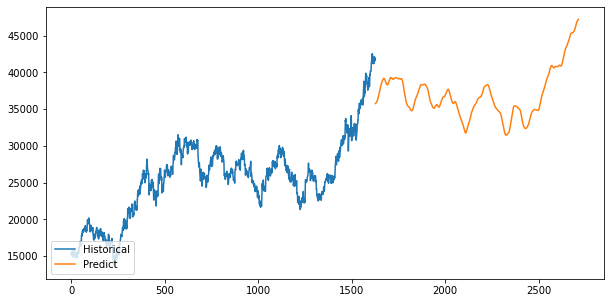

In [111]:
def create_LR_LSTMdataset(dataset,time_step):
    X=[]
    Y=[]
    lag=1086
    for i in range(len(dataset)-time_step-1-lag):
        #print(dataset[0:i,0])
        a=dataset[i:(i+time_step),0]
        X.append(a)
        Y.append(dataset[i+time_step+lag,0])
    X=np.array(X)
    Y=np.array(Y)
    return X,Y

def create_actualpredict_LSTMdataset(dataset,time_step):
    X=[]
    lag=1086
    for i in range((len(dataset)-time_step-lag),(len(dataset)-time_step)):
        a=dataset[i:(i+time_step),0]
        X.append(a)
    X=np.array(X)
    X.reshape(X.shape[0],time_step)
    return X

#LSTM_Data=(df.reset_index()['Close'])

#performing the splitting of DataSets into train and test

# #LSTMtraining_len=int(len(LSTM_Data)*0.80)
# LSTMtrain=np.array(LSTM_Data[:])
# LSTMtest=np.array(LSTM_Data[240:])  

# #scaling the data to the range between 0 and 1

# scaler=MinMaxScaler(feature_range=(0,1))
# LSTMtrain=scaler.fit_transform(LSTMtrain.reshape(-1,1))
# LSTMtest=scaler.fit_transform(LSTMtest.reshape(-1,1))

# LSTM_X_train = create_actualpredict_LSTMdataset(LSTMtrain,500)
# # LSTM_X_test, LSTM_Y_test= create_LR_LSTMdataset(LSTMtest,100)
# print(LSTM_X_train.shape)
# print("This is the",LSTM_X_train.shape)

# LSTM_X_train=LSTM_X_train.reshape(LSTM_X_train.shape[0],LSTM_X_train.shape[1],1)
# print("This is the new",LSTM_X_train.shape)
# # LSTM_X_test=LSTM_X_test.reshape(LSTM_X_test.shape[0],LSTM_X_test.shape[1],1)
# # LSTM_Y_train=LSTM_Y_train.reshape(LSTM_Y_train.shape[0],1)
# # LSTM_Y_test=LSTM_Y_test.reshape(LSTM_Y_test.shape[0],1)

def actual_LSTM_model(timesteps):
    #obtaining the correct data from the dataset
    
    LSTM_DataFrame=df.reset_index()['Close']
    LSTM_Data=np.array(LSTM_DataFrame[:])

    #performing the splitting of DataSets into train and test
    
    #LSTMtraining_len=int(len(LSTM_Data)*0.80)

    #scaling the data to the range between 0 and 1
    
    scaler=MinMaxScaler(feature_range=(0,1))
    LSTMtrain=scaler.fit_transform(LSTM_Data.reshape(-1,1))
    #LSTMtest=scaler.fit_transform(LSTMtest.reshape(-1,1))
    LSTM_X_train, LSTM_Y_train = create_LR_LSTMdataset(LSTMtrain,timesteps)
    LSTM_X_actual = create_actualpredict_LSTMdataset(LSTMtrain,timesteps)
   
    LSTM_X_train=LSTM_X_train.reshape(LSTM_X_train.shape[0],LSTM_X_train.shape[1],1)
    LSTM_X_actual=LSTM_X_actual.reshape(LSTM_X_actual.shape[0],LSTM_X_actual.shape[1],1)
    LSTM_Y_train=LSTM_Y_train.reshape(LSTM_Y_train.shape[0],1)
    # LSTM_Y_test=LSTM_Y_test.reshape(LSTM_Y_test.shape[0],1)

    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(LSTM_X_train.shape[1],1))) #this ensures that the input shape follows the correct 'format'
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    model.fit(LSTM_X_train,LSTM_Y_train,epochs=10,batch_size=32)

    LSTM_test_predict=model.predict(LSTM_X_actual)  #prediction will output an array 
    LSTM_test_predict=scaler.inverse_transform(LSTM_test_predict) #we will then convert the array from scaled values to the original values

    # LSTM_testDatavalues=df.reset_index()['Close'][240+timesteps+1+1087:] #converting to series object in order to plot graph
    # LSTM_testDatavalues=LSTM_testDatavalues.reset_index(drop=True) 
    LSTM_test_predictvalues = pd.DataFrame(LSTM_test_predict).iloc[:,0] #converting to series object in order to plot graph
    LSTM_test_predictvalues.index=pd.RangeIndex(1628,1628+1086)

    plt.figure(figsize=(10,5))
    plt.plot(LSTM_DataFrame,label="Historical")
    plt.plot(LSTM_test_predictvalues,label="Predict")
    plt.legend(loc='lower left')
    plt.show()
    
    LSTM_test_predictvalues_lst = LSTM_test_predictvalues.tolist()
    # LSTM_testDatavalues_lst = LSTM_testDatavalues.tolist()
    #print(LSTM_test_predictvalues_lst)
    #print(LSTM_testDatavalues_lst)
    # print(mean_squared_error(LSTM_testDatavalues_lst,LSTM_test_predictvalues_lst,squared=False))
    return LSTM_test_predictvalues_lst
final_values = actual_LSTM_model(500)

Create a function to write a list of data (the predicted stock prices) into a CSV file.

In [ ]:
write_ans_toCSV(final_values)

Usage of SVM for stock prices. The SVM is a usually more robust version of linear regression, in the sense that it is less sensitive to outliers in the dataset. Applied in the context of the stock market, the algorithm produced will more closely match the general trend of the stock (and be less sensitive to market fluctuations). Thus, the algorithm will be more accurate for long-term investing (for which the day-to-day/ week-to-week fluctuations occur less often). 



In [112]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR


history_close_prices = df['Close'].reset_index(drop=True)
critical_length = int(len(history_close_prices)*0.8)
train_history_close_prices = history_close_prices[:critical_length].tolist()
train_days = [[i] for i in range(1,critical_length+1)]
test_history_close_prices = history_close_prices[critical_length:].tolist()
new_day = critical_length + 1
end_day = new_day + len(test_history_close_prices)
test_days = [[i] for i in range(new_day,end_day)]

Using LinearSVR to predict stock prices

In [113]:
#print(train_days)
#print(train_history_close_prices)

lin_svr = LinearSVR()
lin_svr.fit(train_days, train_history_close_prices)

# poly_svr = SVR(kernel='poly',C=1000, degree=2)
# poly_svr.fit(train_days, train_history_close_prices)

# rbf_svr = SVR(kernel='rbf',C=1000, gamma=0.15)
# rbf_svr.fit(train_days, train_history_close_prices)

C:\Users\65932\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR()

Stock Price Predictions using the SVR model. Validating the model.

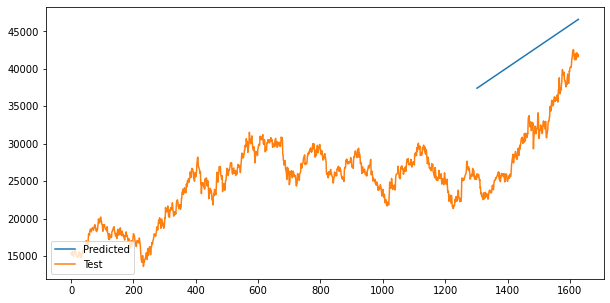

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
11469.80289419135


In [125]:
svr_test_predict=lin_svr.predict(test_days)
svr_predictdf = pd.DataFrame(svr_test_predict)
svr_testdf = pd.DataFrame(test_history_close_prices)
#LSTM_test_predictvalues = pd.DataFrame(LSTM_test_predict).iloc[:,0] #converting to series object in order to plot graph
svr_predictdf.index=pd.RangeIndex(critical_length,1628)
plt.figure(figsize=(10,5))
plt.plot(svr_predictdf,label="Predicted")
plt.plot(history_close_prices,label="Test")
plt.legend(loc='lower left')
plt.show()

#obtaining the RMSE
print(type(svr_predictdf))
print(type(svr_testdf))
lst_svr_predictdf=svr_predictdf.iloc[:,0].tolist()
lst_svr_testdf=svr_testdf.iloc[:,0].tolist()
print(mean_squared_error(lst_svr_predictdf,lst_svr_testdf,squared=False))

SVR yields a result that is pretty far off > Seemingly even further off compared to our ARIMA model. As the LSTM model cannot be validated, we will use our ARIMA model as our main result.